In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

import matplotlib.pyplot as plt

In [2]:
# Training settings
batch_size = 10000

In [3]:

train_transform = transforms.Compose([
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                               train=True,
                               transform=train_transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='/home/lee/Research/11.project_tangqing/data',
                              train=False,
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, # 64
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

dataloaders = {
    'train': train_loader,
    'test' : test_loader    
}
image_datasets = {
    'train': train_dataset,
    'test' : test_dataset
}
dataset_sizes = {
    'train': len(image_datasets['train']),
    'test' : len(image_datasets['test'])
}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('train_size: ',dataset_sizes['train'],'\ntest_size : ',dataset_sizes['test'])
print(classes)
print('len class: ', len(classes))



Files already downloaded and verified
train_size:  50000 
test_size :  10000
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
len class:  10


In [42]:
# for n, class_n in enumerate(classes):
#     a = 'class_n_{}'.format(class_n)
#     print(n, a)

0 class_n_plane
1 class_n_car
2 class_n_bird
3 class_n_cat
4 class_n_deer
5 class_n_dog
6 class_n_frog
7 class_n_horse
8 class_n_ship
9 class_n_truck


In [24]:
# # ADDING NOISE
noise = []
noise = np.random.rand(32, 32,3)
import pickle

# pickle_out = open("batch1","wb")
data = []
filenames = []
occludes = []

for batch_n in range(5):
    inputs, labels = next(iter(dataloaders['train']))
#     print(inputs.shape)
    pickle_out = open("batch{}".format(n+1),"wb")
    data = []
    count = [0 for i in range(10)]
    for m in range(batch_size):
        images_ = inputs[m].numpy()
        class_  = labels[m].numpy()
        images_ = np.transpose(images_, [1,2,0])     # (32x32x3)
        for n, class_n in enumerate(classes):
            if classes[class_] == class_n:
                count[class_] += 1
                if count[class_] < 200:
                    x_random = np.random.randint(6, 27, size=1, dtype='uint8')
                    y_random = np.random.randint(6, 27, size=1, dtype='uint8')
                    w_random = np.random.randint(8, 13, size=1, dtype='uint8')
                    h_random = np.random.randint(8, 13, size=1, dtype='uint8')
                    images_[y_random[0]-int(h_random[0]/2):y_random[0]+int(h_random[0]/2),x_random[0]-int(w_random[0]/2):x_random[0]+int(w_random[0]/2),:]=noise[y_random[0]-int(h_random[0]/2):y_random[0]+int(h_random[0]/2),x_random[0]-int(w_random[0]/2):x_random[0]+int(w_random[0]/2),:]

                    r = images_[:,:,0]
                    g = images_[:,:,1]
                    b = images_[:,:,2]

                    images_[:,:,0] = (r - r.min()) / (r.max() - r.min())
                    images_[:,:,1] = (g - g.min()) / (g.max() - g.min())
                    images_[:,:,2] = (b - b.min()) / (b.max() - b.min())
            #             encode_img = images_.tostring()
                    data.append(images_)
                    filename = '{}_{}_{}.png'.format(classes[class_],class_, batch_n*10000+m)
                    filenames.append(filename)
                    occlude = 1
                    occludes.append(occlude)

#                     plt.imsave('/home/lee/Research/11.project_tangqing/data/cifar-10-occlude/{}_{}.png'.format(classes[class_],class_*10000+m), images_)

                else:
                    r = images_[:,:,0]
                    g = images_[:,:,1]
                    b = images_[:,:,2]

                    images_[:,:,0] = (r - r.min()) / (r.max() - r.min())
                    images_[:,:,1] = (g - g.min()) / (g.max() - g.min())
                    images_[:,:,2] = (b - b.min()) / (b.max() - b.min())
            #             encode_img = images_.tostring()
                    data.append(images_)
                    filename = '{}_{}_{}.png'.format(classes[class_],class_, batch_n*10000+m)
                    filenames.append(filename)
#         print(classes[class_.numpy()])
#                     plt.imsave('/home/lee/Research/11.project_tangqing/data/cifar-10-occlude/{}_{}.png'.format(classes[class_],class_*10000+m), images_)

                    occlude = 0
                    occludes.append(occlude)
#         plt.imshow(images_)
#         plt.show()
        
        
    pickle_cifar10 = {'labels': labels.numpy(),'data': data, 'filenames': filenames, 'occludes': occludes}
    pickle.dump(pickle_cifar10, pickle_out)
    pickle_out.close()
    data.clear()
    filenames.clear()
    count.clear()
    occludes.clear()



In [25]:
def unpickle_1(file):
#     import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

In [26]:
def unpickle(file):
#     import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

9
[[[0.60993844 0.69304043 0.7355832 ]
  [0.49849218 0.5309257  0.53431064]
  [0.41490757 0.39718106 0.3725033 ]
  ...
  [0.35918447 0.36070526 0.27778685]
  [0.3432636  0.3404409  0.27778685]
  [0.31142184 0.3039651  0.27384034]]

 [[0.5542153  0.6241417  0.66454583]
  [0.57411647 0.5957716  0.605348  ]
  [0.49451196 0.48229128 0.4632733 ]
  ...
  [0.3790856  0.3769167  0.30541247]
  [0.3034614  0.29991224 0.24226813]
  [0.2795801  0.27154216 0.23832162]]

 [[0.5542153  0.6038773  0.64481324]
  [0.5502351  0.5674015  0.5856154 ]
  [0.45470977 0.4417626  0.43959415]
  ...
  [0.31142184 0.30801797 0.2501612 ]
  [0.26763943 0.25938356 0.2146425 ]
  [0.2636592  0.25533068 0.2146425 ]]

 ...

 [[0.69352305 0.6525117  0.65270627]
  [0.6178989  0.5998245  0.6290271 ]
  [0.60993844 0.6241417  0.6684923 ]
  ...
  [0.16415368 0.11348031 0.13965861]
  [0.23977786 0.19048479 0.22253554]
  [0.36714494 0.31207085 0.35671723]]

 [[0.65372086 0.5998245  0.5027385 ]
  [0.6178989  0.59171873 0.51063156

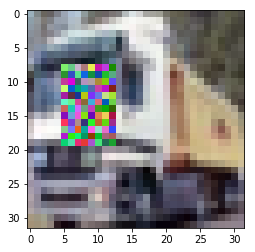

In [27]:
pickle111 = unpickle_1("/home/lee/Research/11.project_tangqing/batch1")
a1 = pickle_in['data'][1]
b1 = pickle_in['labels'][1]

print(b1)
print(a1)

plt.imshow(a1)


In [28]:
b1==b

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [29]:
pickle_in = unpickle("/home/lee/Research/11.project_tangqing/batch1")
a = pickle_in['data'][1]
b = pickle_in['labels'][1]
c = pickle_in['filenames']
# print(b)
# print(a)

print(c)
# plt.imshow(a)


['frog_6_60000.png', 'truck_9_90001.png', 'truck_9_90002.png', 'deer_4_40003.png', 'car_1_10004.png', 'car_1_10005.png', 'bird_2_20006.png', 'horse_7_70007.png', 'ship_8_80008.png', 'cat_3_30009.png', 'deer_4_40010.png', 'horse_7_70011.png', 'horse_7_70012.png', 'bird_2_20013.png', 'truck_9_90014.png', 'truck_9_90015.png', 'truck_9_90016.png', 'cat_3_30017.png', 'bird_2_20018.png', 'frog_6_60019.png', 'deer_4_40020.png', 'cat_3_30021.png', 'frog_6_60022.png', 'frog_6_60023.png', 'bird_2_20024.png', 'frog_6_60025.png', 'cat_3_30026.png', 'dog_5_50027.png', 'deer_4_40028.png', 'plane_0_29.png', 'plane_0_30.png', 'truck_9_90031.png', 'car_1_10032.png', 'cat_3_30033.png', 'deer_4_40034.png', 'plane_0_35.png', 'cat_3_30036.png', 'horse_7_70037.png', 'cat_3_30038.png', 'cat_3_30039.png', 'dog_5_50040.png', 'bird_2_20041.png', 'bird_2_20042.png', 'horse_7_70043.png', 'car_1_10044.png', 'car_1_10045.png', 'car_1_10046.png', 'bird_2_20047.png', 'bird_2_20048.png', 'plane_0_49.png', 'truck_9_900

In [112]:
pickle_in = unpickle("/home/lee/Research/11.project_tangqing/batch1")
print(len(pickle_in['occludes']))
print(pickle_in['occludes'])

# print(a[100])
print(pickle_in['data'][0])
print(pickle_in['labels'])
print(pickle_in['filenames'])


# a = pickle_in['occludes']
# count1 = 0
# for i in range(10000):
#     if pickle_in['labels'][i] == 0:
#         if pickle_in['occludes'][i] == 1:
#             count1 += 1
# print(count1)


[[[0.23137255 0.24505928 0.25244197]
  [0.16862746 0.18181819 0.18031569]
  [0.19607843 0.18972333 0.17230166]
  ...
  [0.61960787 0.5217392  0.43275765]
  [0.59607846 0.49407116 0.40871558]
  [0.5803922  0.49011856 0.4127226 ]]

 [[0.0627451  0.07905138 0.08014031]
  [0.         0.         0.        ]
  [0.07058824 0.03162055 0.        ]
  ...
  [0.48235294 0.3478261  0.22038585]
  [0.46666667 0.32806325 0.20035078]
  [0.47843137 0.34387353 0.22839987]]

 [[0.09803922 0.09486166 0.08414733]
  [0.0627451  0.02766798 0.        ]
  [0.19215687 0.10671937 0.03205612]
  ...
  [0.4627451  0.3320158  0.20035078]
  [0.47058824 0.3320158  0.20035078]
  [0.42745098 0.28853756 0.16829465]]

 ...

 [[0.8156863  0.67193675 0.38467348]
  [0.7882353  0.6047431  0.13623853]
  [0.7764706  0.6363637  0.1041824 ]
  ...
  [0.627451   0.52569175 0.28049108]
  [0.21960784 0.12252964 0.02804911]
  [0.20784314 0.13438736 0.08014031]]

 [[0.7058824  0.5494071  0.38467348]
  [0.6784314  0.486166   0.16829465]
